# Bayesian Inference for Binary Star Eccentricities

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 2 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

Binary stars—gravitationally bound pairs of stars orbiting their common center of mass—are among the most fundamental objects in astrophysics. They serve as cosmic laboratories where we can directly measure stellar masses, test theories of stellar evolution, and probe the physics of star formation. Yet despite their importance, measuring the orbital properties of binary systems remains a significant observational challenge.

Traditional approaches to characterizing binary orbits require extensive monitoring campaigns. Astronomers must observe these systems over multiple orbital periods, carefully tracking the positions and velocities of both stars as they trace their elliptical paths through space. For binaries with orbital periods spanning years or decades, this demands patient, long-term dedication of telescope resources—a luxury that becomes impractical when studying large populations.

This tutorial explores a powerful alternative approach inspired by [Hwang et al. (2022)](https://arxiv.org/abs/2111.01789): using Bayesian inference to constrain orbital eccentricity from single-epoch observations. The key insight lies in recognizing that even a single observation encodes information about the underlying orbit. When we measure a binary star's relative positions and velocities at one moment in time, the angle between these vectors—which we'll denote as γ—provides a statistical constraint on the orbital eccentricity.

Through this tutorial, we'll develop a complete Bayesian framework to understand how:
- The velocity-position angle γ relates to orbital eccentricity through Kepler's laws
- We can construct likelihood functions that connect observable quantities to physical parameters
- Marginalization over unknown orbital phase provides probabilistic constraints on eccentricity
- Orbital inclination and measurement uncertainties affect our inference

This analysis exemplifies how Bayesian methods transform limited observational data into meaningful physical constraints, even when traditional deterministic approaches would fail.

## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Python Programming**: Working knowledge of NumPy, matplotlib, and scipy for scientific computing
- **Probability Theory**: Understanding of probability distributions, Bayes' theorem, and the concept of likelihood
- **Basic Astronomy**: Familiarity with stellar properties and orbital mechanics at an introductory level
- **Statistical Concepts**: Prior exposure to concepts like marginalization, posterior distributions, and sampling methods

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Bayesian Framework**: Constructing likelihood functions and posterior distributions for astronomical observations
- **Forward Modeling**: Building generative models that connect physical parameters to observable quantities
- **Uncertainty Propagation**: Understanding how measurement uncertainties affect inference through marginalization
- **Grid-Based Methods**: Implementing efficient numerical techniques for Bayesian calculations in low-dimensional parameter spaces
- **Physical Intuition**: Connecting mathematical formalism to the underlying orbital mechanics

Let's begin by setting up our computational environment:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import powerlaw
import matplotlib.patches as patches

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set color palette for consistent styling
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## Understanding Binary Star Orbits

Binary stars orbit their common center of mass following Kepler's laws, just as planets orbit the Sun. The shape and orientation of these orbits encode crucial information about the system's formation history and dynamical evolution. To develop our Bayesian framework, we must first understand how orbital parameters translate into observable quantities.

### Orbital Parameters

A binary star orbit is fully characterized by several parameters, but for this tutorial we focus on three key elements:

1. **Semi-major axis ($a$)**: The size scale of the orbit, determining the average separation between the stars
2. **Eccentricity ($e$)**: A measure of how "stretched" the orbit is, ranging from 0 (circular) to nearly 1 (highly elongated)
3. **Inclination ($i$)**: The tilt of the orbital plane relative to our line of sight

The eccentricity parameter is particularly important for understanding binary formation. Different formation mechanisms predict distinct eccentricity distributions:
- **Capture scenarios** often produce highly eccentric orbits
- **Disk fragmentation** tends to create nearly circular orbits
- **Dynamical interactions** can produce a thermal distribution of eccentricities

By measuring the eccentricity distribution across a population of binaries, we can constrain which formation mechanisms dominate in different environments. This makes eccentricity a powerful diagnostic tool for binary star physics.

Let's visualize how these parameters affect the observable properties of binary orbits:

In [2]:
def plot_binary_orbit(a=1.0, e=0.5, i=0.0, phases=100):
    """
    Visualize a binary star orbit with given orbital parameters.
    
    This function demonstrates how orbital eccentricity and inclination
    affect the apparent shape of a binary orbit as seen from Earth.
    
    Parameters:
    -----------
    a : float
        Semi-major axis in astronomical units (AU)
    e : float
        Eccentricity (0 ≤ e < 1)
    i : float
        Inclination angle in degrees (0° = face-on, 90° = edge-on)
    phases : int
        Number of points to plot along the orbit
    """
    # Generate true anomaly (angle from periapsis)
    theta = np.linspace(0, 2*np.pi, phases)
    
    # Calculate radius at each orbital phase using Kepler's equation
    # This is the fundamental equation relating position to orbital phase
    r = a * (1 - e**2) / (1 + e * np.cos(theta))
    
    # Convert polar coordinates to Cartesian
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # Apply inclination - this projects the orbit as seen from Earth
    y_projected = y * np.cos(np.radians(i))
    z = r * np.sin(theta) * np.sin(np.radians(i))
    
    # Create figure with two viewing angles
    fig = plt.figure(figsize=(16, 8))
    
    # Face-on view (as if looking down on the orbital plane)
    ax1 = fig.add_subplot(121)
    ax1.plot(x, y_projected, color='navy', linewidth=3, label='Secondary orbit')
    ax1.plot([0], [0], color='gold', marker='*', markersize=30, label='Primary star')
    
    # Mark periapsis (closest approach) and apoapsis (farthest point)
    periapsis_idx = np.argmin(r)
    apoapsis_idx = np.argmax(r)
    ax1.plot(x[periapsis_idx], y_projected[periapsis_idx], 'ro', 
             markersize=10, label='Periapsis')
    ax1.plot(x[apoapsis_idx], y_projected[apoapsis_idx], 'bo', 
             markersize=10, label='Apoapsis')
    
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlabel('x (AU)')
    ax1.set_ylabel('y (AU)')
    ax1.set_title(f'Sky Projection\n(a={a} AU, e={e}, i={i}°)')
    ax1.legend(loc='upper right')
    
    # Edge-on view
    ax2 = fig.add_subplot(122)
    ax2.plot(x, z, color='navy', linewidth=3)
    ax2.plot([0], [0], color='gold', marker='*', markersize=30)
    ax2.plot(x[periapsis_idx], z[periapsis_idx], 'ro', markersize=10)
    ax2.plot(x[apoapsis_idx], z[apoapsis_idx], 'bo', markersize=10)
    
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlabel('x (AU)')
    ax2.set_ylabel('z (AU)')
    ax2.set_title('Edge-on View')
    
    plt.tight_layout()
    plt.show()

### Effect of Eccentricity on Orbit Shape

The eccentricity parameter fundamentally controls the shape of binary orbits. A circular orbit (e = 0) maintains constant separation between the stars, while highly eccentric orbits (e → 1) bring the stars dramatically closer at periapsis than at apoapsis. This variation in separation directly affects the observable velocities and accelerations throughout the orbit.

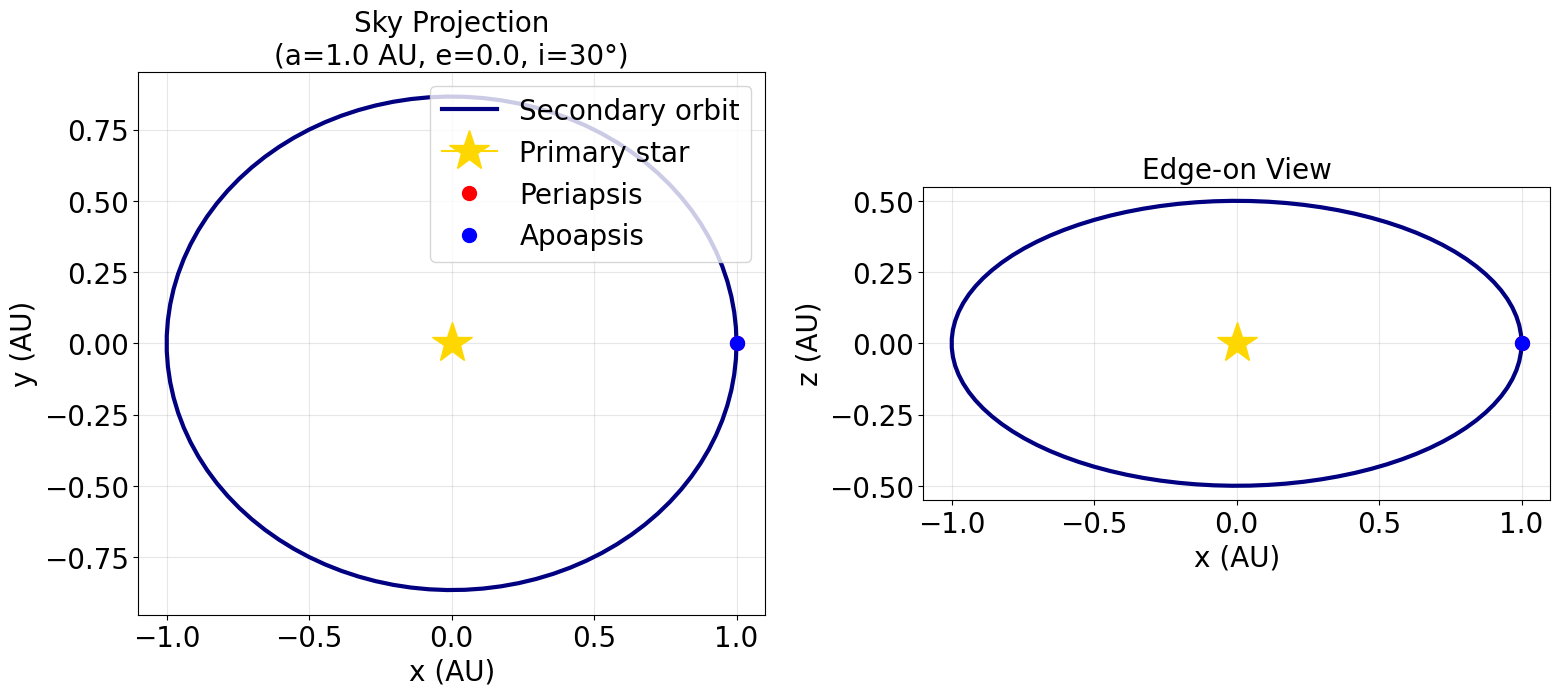

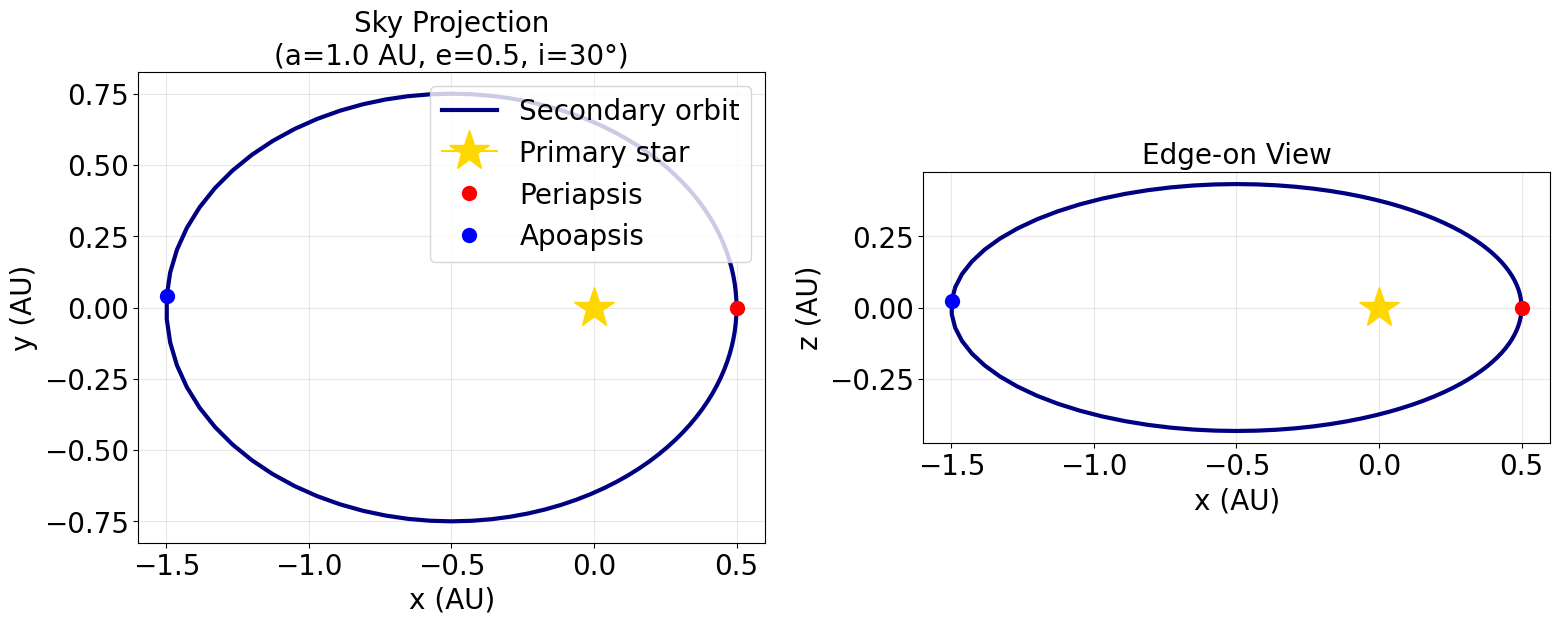

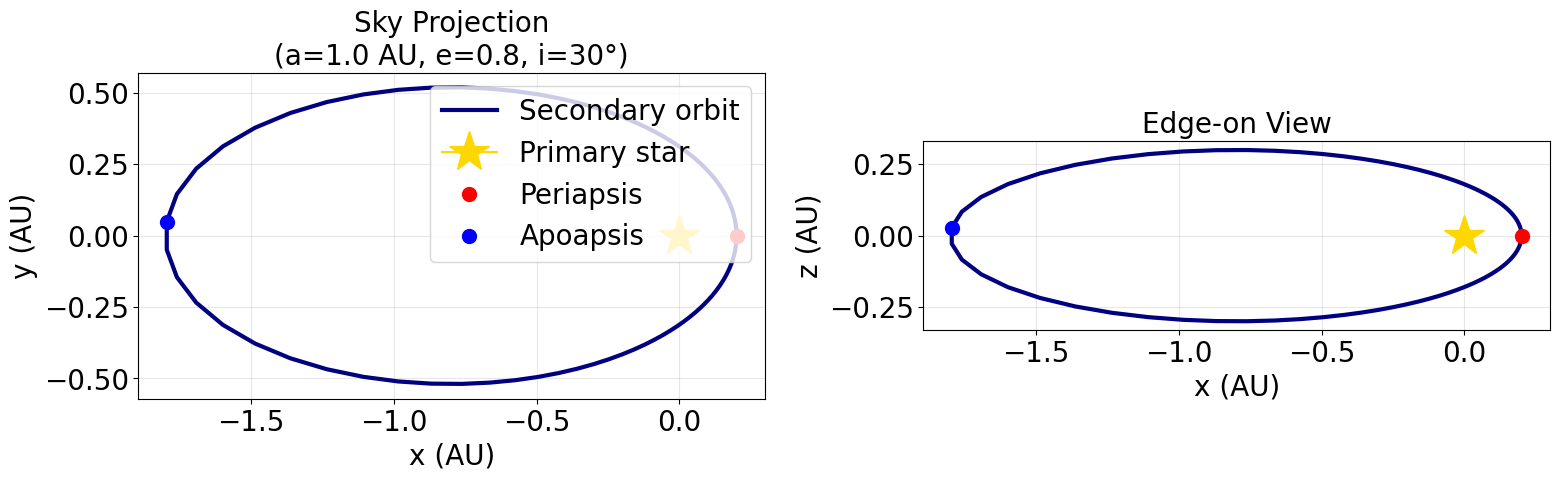

In [3]:
# Demonstrate the effect of eccentricity on orbit shape
plot_binary_orbit(e=0.0, i=30)
plot_binary_orbit(e=0.5, i=30)
plot_binary_orbit(e=0.8, i=30)

### Effect of Inclination on Observed Shape

The inclination angle dramatically affects how we observe binary orbits from Earth. A face-on orbit (i = 0°) reveals the true elliptical shape, while an edge-on orbit (i = 90°) appears as a line. Intermediate inclinations create foreshortened ellipses, where the apparent eccentricity differs from the true value. This projection effect introduces a fundamental ambiguity: without additional information, we cannot distinguish between a circular orbit viewed edge-on and an eccentric orbit viewed face-on.

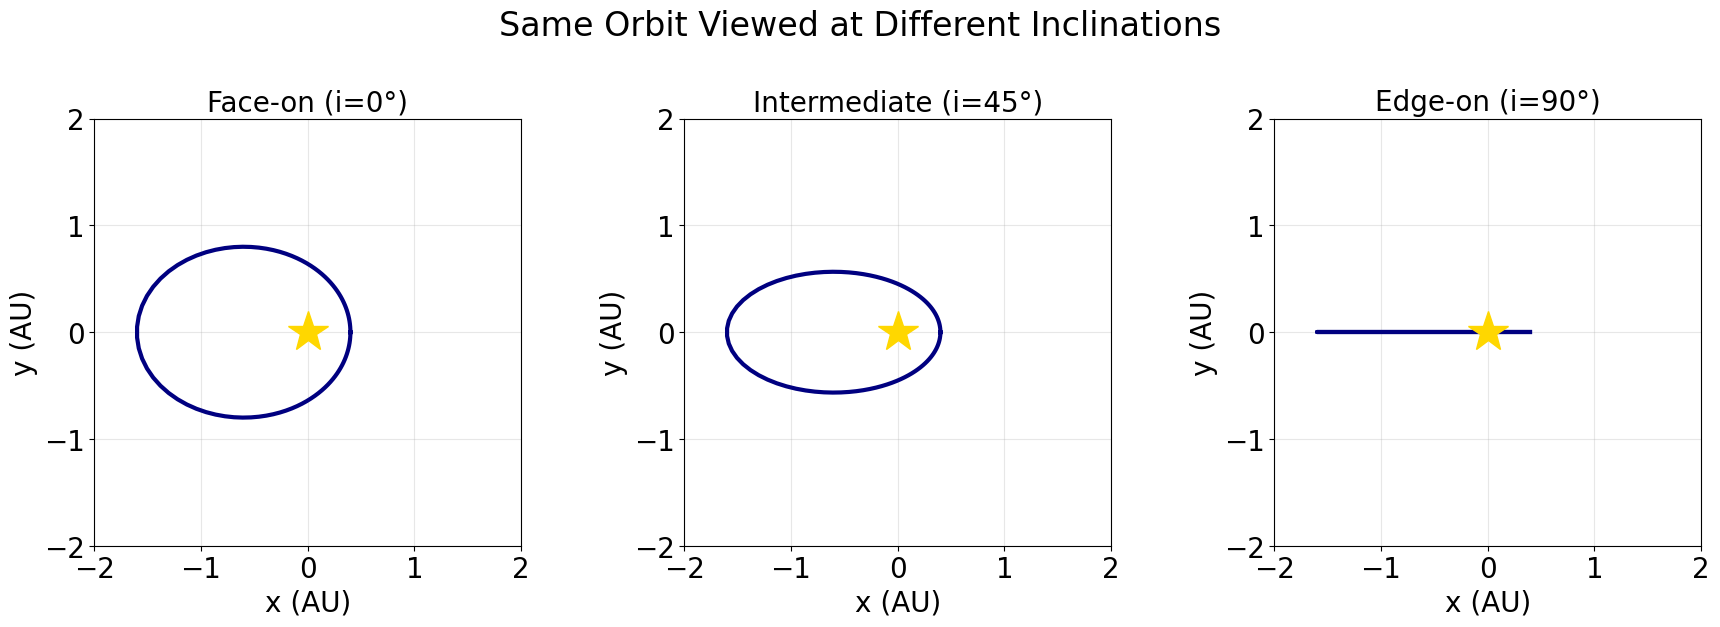

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

inclinations = [0, 45, 90]
descriptions = ['Face-on', 'Intermediate', 'Edge-on']

for ax, i, desc in zip(axes, inclinations, descriptions):
    # Generate orbit
    theta = np.linspace(0, 2*np.pi, 100)
    e = 0.6  # Fixed eccentricity for comparison
    r = 1.0 * (1 - e**2) / (1 + e * np.cos(theta))
    x = r * np.cos(theta)
    y = r * np.sin(theta) * np.cos(np.radians(i))
    
    # Plot
    ax.plot(x, y, color='navy', linewidth=3)
    ax.plot([0], [0], color='gold', marker='*', markersize=30)
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x (AU)')
    ax.set_ylabel('y (AU)')
    ax.set_title(f'{desc} (i={i}°)')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

plt.suptitle('Same Orbit Viewed at Different Inclinations', fontsize=24, y=1.02)
plt.tight_layout()
plt.show()

## The Physics of Orbital Motion

Understanding how stars move within their orbits is crucial for our analysis. At any point in a binary orbit, the relative velocity vector $\vec{v}$ and position vector $\vec{r}$ form an angle that depends on both the orbital eccentricity and the current orbital phase. This relationship provides the key to inferring eccentricity from single-epoch observations.

### The Velocity-Position Angle

Consider a star at some point in its elliptical orbit. Its velocity vector points along its instantaneous direction of motion, while the position vector points from one star to the other. The angle γ between these vectors varies systematically around the orbit:

- **At periapsis**: The star moves perpendicular to the radius vector (γ ≈ 90°)
- **At apoapsis**: Also perpendicular motion (γ ≈ 90°)
- **Between extremes**: The angle varies, encoding information about the eccentricity

For circular orbits, this angle remains constant at 90° everywhere—the hallmark of uniform circular motion. But for eccentric orbits, the variation in γ directly reflects the orbital shape. This makes γ a powerful diagnostic: even from a single observation, we can gain statistical constraints on the eccentricity.

Let's explore this relationship mathematically and visually:

In [5]:
def calculate_orbital_dynamics(e, phase_angles):
    """
    Calculate position and velocity vectors for points along an orbit.
    
    For a Keplerian orbit, we can derive the velocity components from
    conservation of angular momentum and energy.
    """
    # Position in polar coordinates
    r = (1 - e**2) / (1 + e * np.cos(phase_angles))
    
    # Cartesian position
    x = r * np.cos(phase_angles)
    y = r * np.sin(phase_angles)
    
    # Velocity components (normalized to unit semi-major axis and mass)
    # These come from differentiating the orbital equations
    vx = -np.sin(phase_angles) / np.sqrt(1 - e**2)
    vy = (np.cos(phase_angles) + e) / np.sqrt(1 - e**2)
    
    return x, y, vx, vy

def plot_velocity_vectors(e=0.6):
    """
    Visualize velocity vectors at different points around an eccentric orbit.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Full orbit
    theta_full = np.linspace(0, 2*np.pi, 200)
    x_full, y_full, _, _ = calculate_orbital_dynamics(e, theta_full)
    
    # Selected points for vector visualization
    theta_points = np.array([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 
                            5*np.pi/4, 3*np.pi/2, 7*np.pi/4])
    x, y, vx, vy = calculate_orbital_dynamics(e, theta_points)
    
    # Left panel: Orbit with velocity vectors
    ax1.plot(x_full, y_full, 'k-', linewidth=2, alpha=0.5)
    ax1.plot(0, 0, 'yo', markersize=20, markeredgecolor='orange', 
             markeredgewidth=2, label='Primary star')
    
    # Scale velocity vectors for visibility
    scale = 0.3
    
    for i in range(len(x)):
        # Position vector (from origin to star)
        ax1.arrow(0, 0, x[i]*0.95, y[i]*0.95, 
                 head_width=0.05, head_length=0.05, 
                 fc='blue', ec='blue', alpha=0.5, linewidth=2)
        
        # Velocity vector (from star position)
        ax1.arrow(x[i], y[i], vx[i]*scale, vy[i]*scale,
                 head_width=0.05, head_length=0.05,
                 fc='red', ec='red', linewidth=2)
        
        # Calculate and display angle
        dot_product = (x[i]*vx[i] + y[i]*vy[i]) / (np.sqrt(x[i]**2 + y[i]**2) * 
                                                    np.sqrt(vx[i]**2 + vy[i]**2))
        angle = np.degrees(np.arccos(np.clip(dot_product, -1, 1)))
        
        # Add angle annotation
        if i % 2 == 0:  # Annotate every other point to avoid crowding
            ax1.annotate(f'{angle:.0f}°', 
                        xy=(x[i]*1.2, y[i]*1.2), 
                        fontsize=14, ha='center')
    
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlabel('x (AU)')
    ax1.set_ylabel('y (AU)')
    ax1.set_title(f'Velocity Vectors Around Orbit (e={e})')
    ax1.arrow(0, 0, 0, 0, head_width=0.1, fc='blue', ec='blue', 
              label='Position vectors')
    ax1.arrow(0, 0, 0, 0, head_width=0.1, fc='red', ec='red', 
              label='Velocity vectors')
    ax1.legend(loc='upper right')
    
    # Right panel: Angle variation with phase
    theta_continuous = np.linspace(0, 2*np.pi, 200)
    x_cont, y_cont, vx_cont, vy_cont = calculate_orbital_dynamics(e, theta_continuous)
    
    # Calculate angles
    dot_products = (x_cont*vx_cont + y_cont*vy_cont) / (
        np.sqrt(x_cont**2 + y_cont**2) * np.sqrt(vx_cont**2 + vy_cont**2))
    angles = np.degrees(np.arccos(np.clip(dot_products, -1, 1)))
    
    ax2.plot(theta_continuous*180/np.pi, angles, 'k-', linewidth=3)
    ax2.scatter(theta_points*180/np.pi, 
                np.degrees(np.arccos(np.clip((x*vx + y*vy) / 
                          (np.sqrt(x**2 + y**2) * np.sqrt(vx**2 + vy**2)), -1, 1))),
                color='red', s=100, zorder=5)
    
    ax2.grid(True, alpha=0.3)
    ax2.set_xlabel('Orbital Phase (degrees)')
    ax2.set_ylabel('γ (degrees)')
    ax2.set_title('Velocity-Position Angle vs. Orbital Phase')
    ax2.set_xlim(0, 360)
    ax2.axhline(y=90, color='gray', linestyle='--', alpha=0.5, 
                label='90° (perpendicular)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

For circular orbits (e = 0), the velocity is always perpendicular to the position vector, maintaining a constant angle of 90° throughout the orbit. This reflects the fundamental property of uniform circular motion. As eccentricity increases, the angle varies more dramatically, encoding information about the orbital shape in the instantaneous geometry.

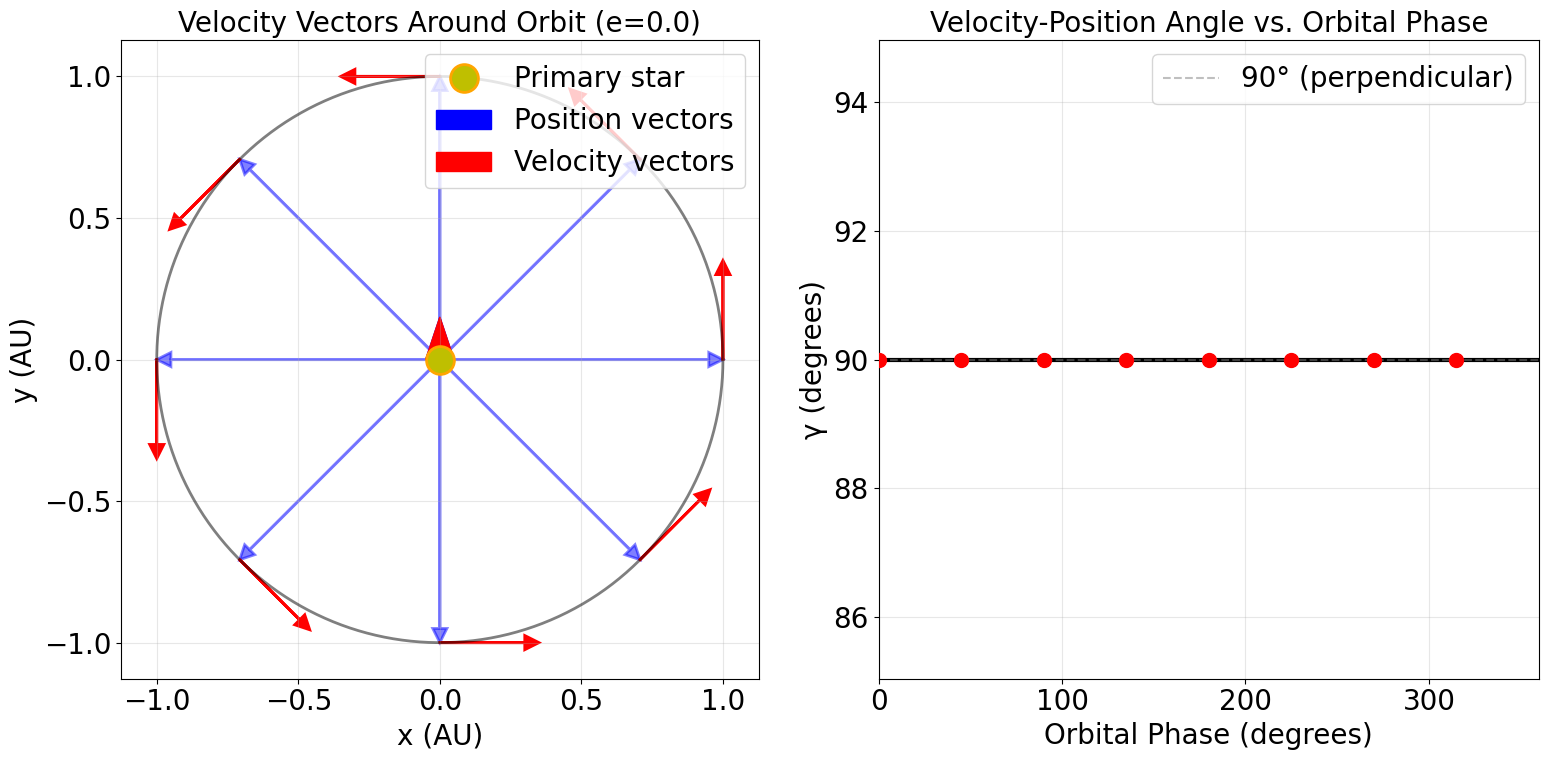

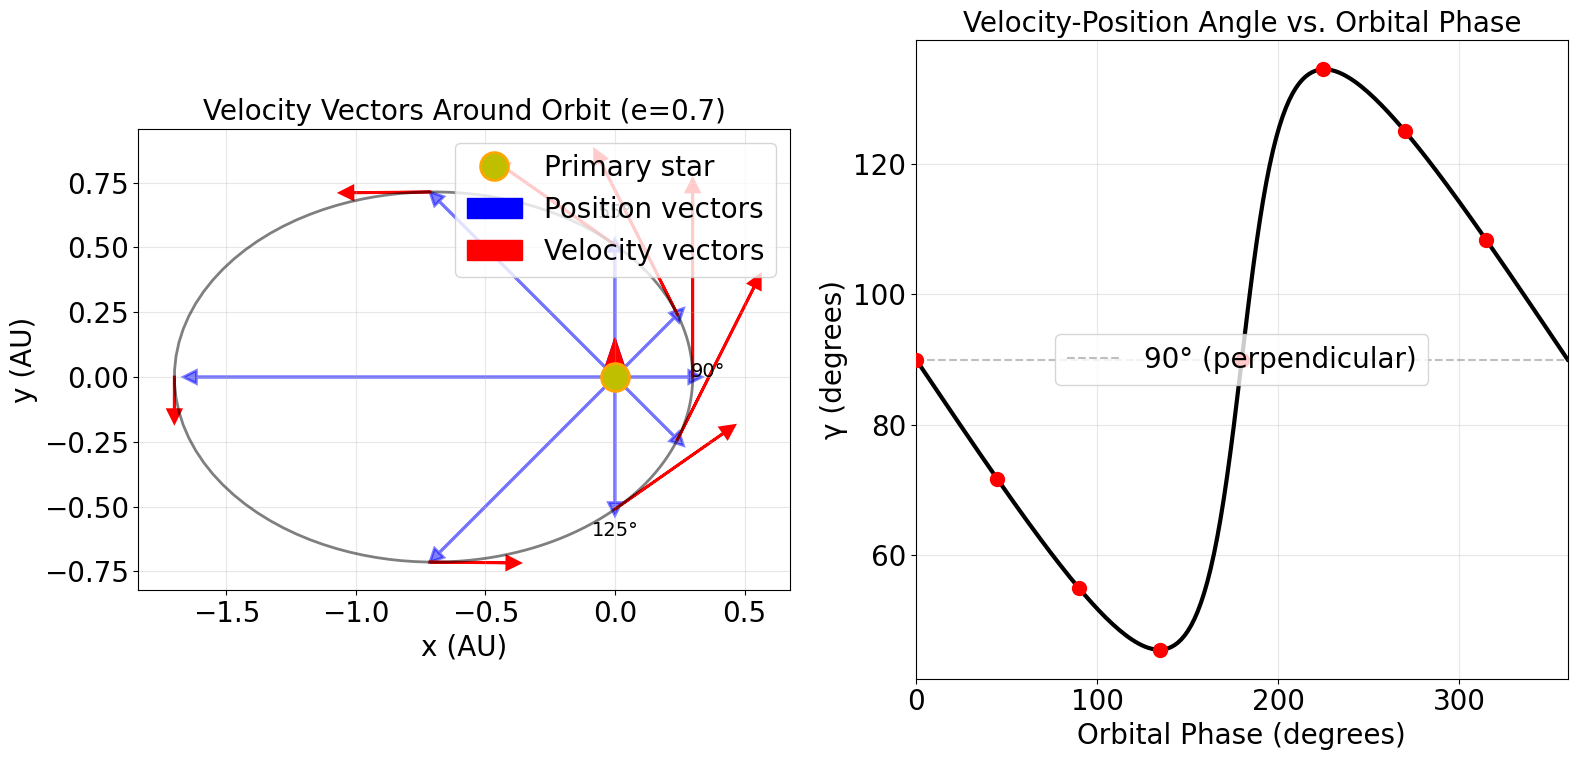

In [6]:
# Demonstrate for different eccentricities
plot_velocity_vectors(e=0.0)
plot_velocity_vectors(e=0.7)

## Mathematical Framework: From Angles to Eccentricity

Having visualized the relationship between orbital geometry and the velocity-position angle, we now develop the mathematical framework that enables our Bayesian analysis. The key is understanding how the observable angle γ depends on the orbital parameters.

For a Keplerian orbit viewed face-on, the cosine of the angle between the position and velocity vectors can be expressed as:

$$\cos(\gamma_{3D}) = \frac{e \sin(\phi)}{\sqrt{1 + e^2 + 2e\cos(\phi)}}$$

where:
- $e$ is the orbital eccentricity (0 ≤ e < 1)
- $\phi$ is the orbital phase (0 ≤ φ < 2π)
- $\gamma_{3D}$ is the three-dimensional angle between $\vec{r}$ and $\vec{v}$

This equation encapsulates the entire relationship between orbital shape and instantaneous geometry. Several limiting cases help build intuition:

1. **Circular orbit (e = 0)**: The numerator vanishes, giving cos(γ) = 0, hence γ = 90° everywhere
2. **At periapsis (φ = 0)**: Both sine and cosine terms vanish, giving γ = 90°
3. **At apoapsis (φ = π)**: Similar result, γ = 90°
4. **Maximum deviation**: Occurs at intermediate phases, with the exact location depending on eccentricity

Let's implement this relationship and explore its properties:

In [7]:
def cos_gamma_3D(e, phi):
    """
    Calculate cos(gamma_3D) for given eccentricity and orbital phase.
    
    This implements the fundamental equation relating the velocity-position
    angle to orbital parameters for face-on orbits.
    
    Parameters:
    -----------
    e : float or array
        Orbital eccentricity (0 ≤ e < 1)
    phi : float or array  
        Orbital phase in radians (0 ≤ φ < 2π)
        
    Returns:
    --------
    cos_gamma : float or array
        Cosine of the 3D angle between position and velocity vectors
    """
    numerator = e * np.sin(phi)
    denominator = np.sqrt(1.0 + e**2 + 2.0*e*np.cos(phi))
    
    # Avoid division by zero with small epsilon
    cos_gamma = numerator / np.maximum(denominator, 1e-15)
    
    # Ensure valid cosine values
    return np.clip(cos_gamma, -1.0, 1.0)

The fundamental equation reveals several important properties of the velocity-position angle relationship. First, circular orbits (e = 0) maintain a constant γ = 90° at all phases, confirming our physical intuition. As eccentricity increases, the angle varies more dramatically throughout the orbit, with the distribution becoming increasingly bimodal.

Let's systematically explore these relationships, starting with how γ varies with orbital phase for different eccentricities:

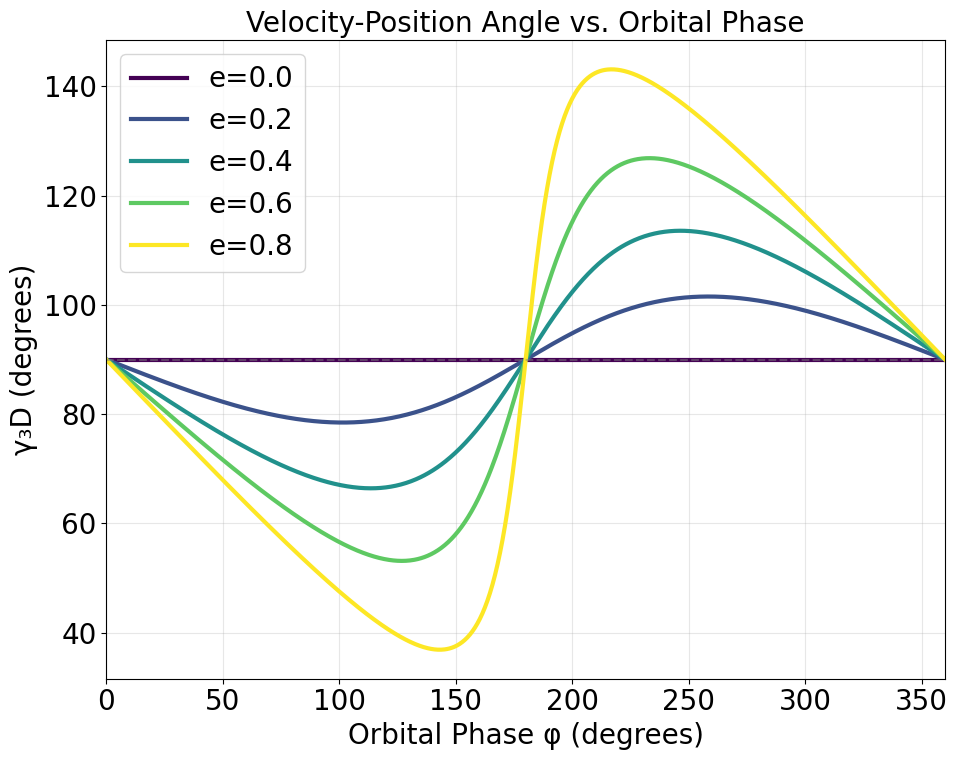

In [8]:
# First, let's explore how the angle varies with orbital phase for different eccentricities
fig, ax = plt.subplots(figsize=(10, 8))

phi_range = np.linspace(0, 2*np.pi, 1000)
eccentricities = [0.0, 0.2, 0.4, 0.6, 0.8]
colors = plt.cm.viridis(np.linspace(0, 1, len(eccentricities)))

for e, color in zip(eccentricities, colors):
    gamma = np.degrees(np.arccos(cos_gamma_3D(e, phi_range)))
    ax.plot(phi_range*180/np.pi, gamma, color=color, linewidth=3, label=f'e={e}')

ax.set_xlabel('Orbital Phase φ (degrees)')
ax.set_ylabel('γ₃D (degrees)')
ax.set_title('Velocity-Position Angle vs. Orbital Phase')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xlim(0, 360)
ax.axhline(y=90, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

The periodic variation in γ demonstrates how eccentricity shapes the velocity-position relationship. For circular orbits, the constant 90° angle reflects uniform circular motion. As eccentricity increases, we observe symmetric oscillations around 90°, with the amplitude growing monotonically with e. The extrema occur at intermediate orbital phases rather than at periapsis or apoapsis—a non-intuitive result that emerges from the orbital dynamics.


Let's visualize how γ depends on both eccentricity and orbital phase simultaneously:

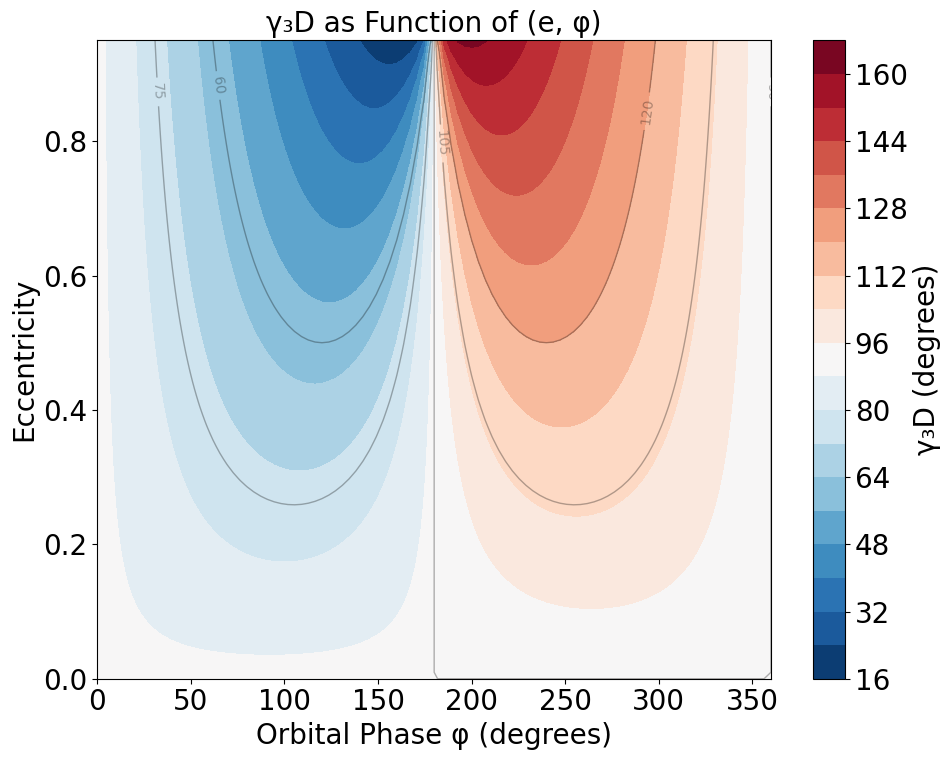

In [9]:
# Create a 2D map showing γ as a function of both e and φ
fig, ax = plt.subplots(figsize=(10, 8))

e_grid = np.linspace(0, 0.95, 100)
phi_grid = np.linspace(0, 2*np.pi, 100)
E, PHI = np.meshgrid(e_grid, phi_grid)
GAMMA = np.degrees(np.arccos(cos_gamma_3D(E, PHI)))

im = ax.contourf(PHI*180/np.pi, E, GAMMA, levels=20, cmap='RdBu_r')
ax.set_xlabel('Orbital Phase φ (degrees)')
ax.set_ylabel('Eccentricity')
ax.set_title('γ₃D as Function of (e, φ)')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('γ₃D (degrees)')

# Add contour lines for clarity
contours = ax.contour(PHI*180/np.pi, E, GAMMA, levels=[60, 75, 90, 105, 120], 
                      colors='black', alpha=0.3, linewidths=1)
ax.clabel(contours, inline=True, fontsize=10)

plt.tight_layout()
plt.show()

This map reveals the full parameter space connecting orbital geometry to observable angles. The symmetric pattern around φ = 180° reflects the orbital symmetry, while the expanding range with eccentricity confirms our earlier findings. Notably, for any observed γ ≠ 90°, multiple (e, φ) combinations can produce the same angle, highlighting the degeneracy inherent in single-epoch observations.

Finally, let's examine the distribution of γ values we would observe if we randomly sampled orbital phases for a fixed eccentricity:


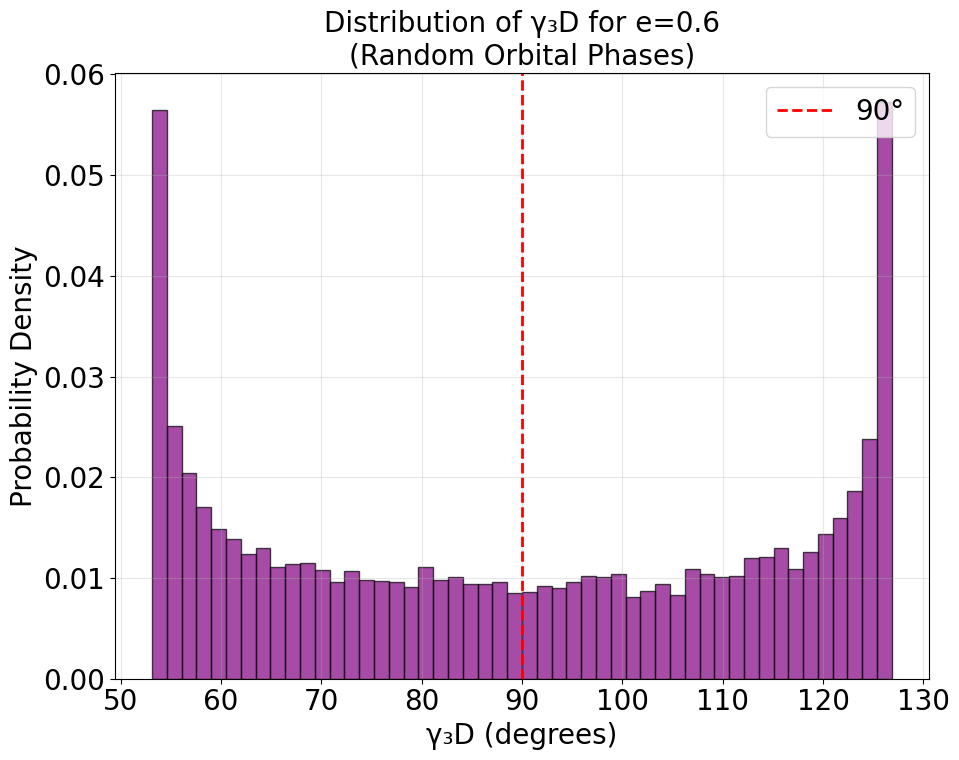

In [10]:
# Distribution of angles for fixed eccentricity with random orbital phases
fig, ax = plt.subplots(figsize=(10, 8))

e_test = 0.6
n_samples = 10000
phi_random = np.random.uniform(0, 2*np.pi, n_samples)
gamma_random = np.degrees(np.arccos(cos_gamma_3D(e_test, phi_random)))

ax.hist(gamma_random, bins=50, density=True, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(x=90, color='red', linestyle='--', linewidth=2, label='90°')
ax.set_xlabel('γ₃D (degrees)')
ax.set_ylabel('Probability Density')
ax.set_title(f'Distribution of γ₃D for e={e_test}\n(Random Orbital Phases)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Bayesian Inference: From Observations to Eccentricity

Having established the relationship between the velocity-position angle γ and orbital eccentricity, we now develop a Bayesian framework to infer eccentricity from observations. The challenge is that a single measurement of γ cannot uniquely determine the eccentricity—multiple combinations of (e, φ) can produce the same observed angle.

### The Forward Problem

We've already solved the forward problem: given eccentricity e and orbital phase φ, we can calculate the expected angle:

$$\cos(\gamma_{3D}) = \frac{e \sin(\phi)}{\sqrt{1 + e^2 + 2e\cos(\phi)}}$$

But in practice, we measure γ and want to infer e. This is an inverse problem, and Bayesian inference provides the natural framework for handling the inherent uncertainties.

### Building the Likelihood Function

The first step in Bayesian inference is constructing the likelihood function p(γ|e). This tells us: given a true eccentricity e, what is the probability of observing a particular angle γ?

Since the orbital phase φ is unknown and effectively random for a single observation, we must marginalize over it:

$$p(\gamma|e) = \int_0^{2\pi} p(\gamma|e,\phi) p(\phi) d\phi$$

Assuming uniform distribution for the phase, p(φ) = 1/(2π), this becomes an average over all possible orbital phases. Let's implement this numerically:

In [11]:
def compute_likelihood_grid(gamma_obs_deg, e_values, n_phase_samples=10000):
    """
    Compute the likelihood p(γ|e) for a grid of eccentricity values.
    
    Since we don't know the orbital phase, we marginalize over it by
    sampling many random phases and counting how often we get γ close
    to our observed value.
    
    Parameters:
    -----------
    gamma_obs_deg : float
        Observed angle in degrees
    e_values : array
        Grid of eccentricity values to evaluate
    n_phase_samples : int
        Number of random phase samples for Monte Carlo integration
        
    Returns:
    --------
    likelihood : array
        Likelihood values p(γ|e) for each eccentricity
    """
    likelihood = np.zeros_like(e_values)
    
    # Width of the γ bin (in degrees) - this represents measurement precision
    bin_width = 1.0
    
    for i, e in enumerate(e_values):
        # Sample random orbital phases
        phi_samples = np.random.uniform(0, 2*np.pi, n_phase_samples)
        
        # Calculate γ for each phase
        cos_gamma = cos_gamma_3D(e, phi_samples)
        gamma_samples = np.degrees(np.arccos(cos_gamma))
        
        # Count fraction falling within our observation bin
        within_bin = np.abs(gamma_samples - gamma_obs_deg) < bin_width/2
        likelihood[i] = np.sum(within_bin) / n_phase_samples
    
    # Normalize (though not strictly necessary for Bayesian inference)
    if np.sum(likelihood) > 0:
        likelihood = likelihood / np.trapz(likelihood, e_values)
    
    return likelihood

The likelihood function p(γ|e) encodes how probable our observation is for different eccentricity values. Let's examine how these likelihood functions behave for different observed angles:

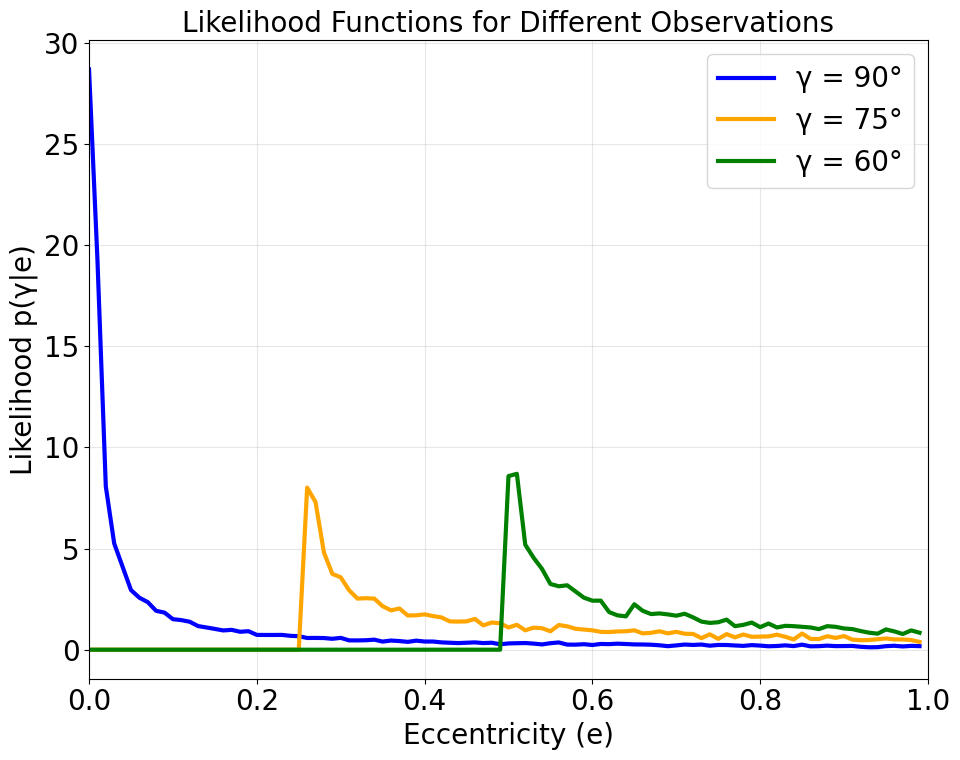

In [12]:
# Demonstrate likelihood functions for different observed angles
fig, ax = plt.subplots(figsize=(10, 8))

# Test different observed angles
gamma_observations = [90, 75, 60]
colors = ['blue', 'orange', 'green']
e_grid = np.linspace(0, 0.99, 100)

for gamma_obs, color in zip(gamma_observations, colors):
    likelihood = compute_likelihood_grid(gamma_obs, e_grid)
    ax.plot(e_grid, likelihood, color=color, linewidth=3, 
            label=f'γ = {gamma_obs}°')

ax.set_xlabel('Eccentricity (e)')
ax.set_ylabel('Likelihood p(γ|e)')
ax.set_title('Likelihood Functions for Different Observations')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

The likelihood functions reveal important insights. An observation of γ = 90° is consistent with all eccentricities, though low eccentricities are more probable since circular orbits always maintain 90°. As γ deviates from 90°, the likelihood becomes increasingly peaked, providing stronger constraints on eccentricity. Extreme angles strongly favor high eccentricities, as only elongated orbits can produce such large deviations from perpendicular motion.

To better understand the relationship between observations and eccentricity constraints, let's create a comprehensive likelihood map:

Computing 2D likelihood map (this may take a moment)...


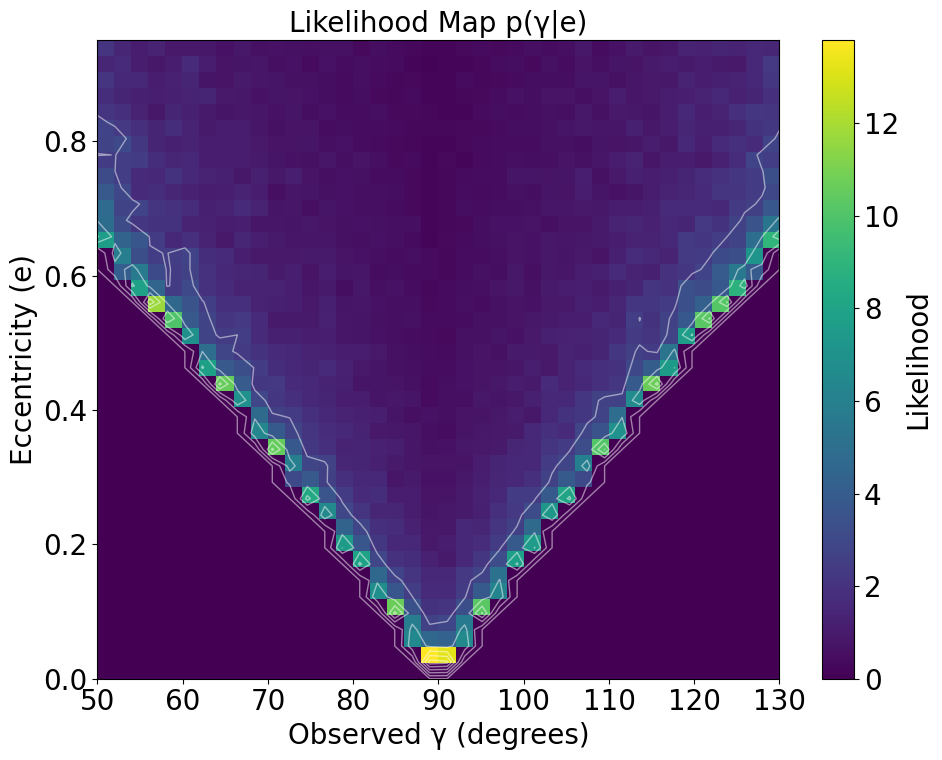

In [13]:
# Create a 2D likelihood map
fig, ax = plt.subplots(figsize=(10, 8))

print("Computing 2D likelihood map (this may take a moment)...")
gamma_range = np.linspace(50, 130, 40)
e_range = np.linspace(0, 0.95, 40)
likelihood_map = np.zeros((len(gamma_range), len(e_range)))

for i, gamma in enumerate(gamma_range):
    likelihood_map[i, :] = compute_likelihood_grid(gamma, e_range, n_phase_samples=5000)

im = ax.imshow(likelihood_map.T, origin='lower', aspect='auto', 
               extent=[gamma_range[0], gamma_range[-1], e_range[0], e_range[-1]],
               cmap='viridis')
ax.set_xlabel('Observed γ (degrees)')
ax.set_ylabel('Eccentricity (e)')
ax.set_title('Likelihood Map p(γ|e)')
plt.colorbar(im, ax=ax, label='Likelihood')

# Add contour lines
contours = ax.contour(gamma_range, e_range, likelihood_map.T, 
                      levels=5, colors='white', alpha=0.5, linewidths=1)

plt.tight_layout()
plt.show()

### From Likelihood to Posterior: Applying Bayes' Theorem

With our likelihood function in hand, we can now apply Bayes' theorem to infer the posterior distribution of eccentricities given an observation:

$$p(e|\gamma) = \frac{p(\gamma|e) p(e)}{p(\gamma)}$$

where:
- $p(e|\gamma)$ is the **posterior**: what we want to know (probability of eccentricity given our observation)
- $p(\gamma|e)$ is the **likelihood**: what we just computed
- $p(e)$ is the **prior**: our initial belief about eccentricity distribution
- $p(\gamma)$ is the **evidence**: a normalization constant

For this analysis, we'll use an uninformative (uniform) prior: $p(e) = 1$ for $e \in [0,1]$. This represents maximal ignorance—we assume all eccentricities are equally likely before seeing the data. The evidence $p(\gamma)$ ensures our posterior integrates to 1, but since we're comparing relative probabilities, we can ignore it and normalize afterward.

In [14]:
def calculate_posterior(gamma_obs_deg, e_grid=None, n_samples=50000):
    """
    Calculate the posterior distribution p(e|γ) using Bayes' theorem.
    
    With uniform prior p(e) = 1, the posterior is proportional to the likelihood:
    p(e|γ) ∝ p(γ|e) p(e) = p(γ|e)
    
    Parameters:
    -----------
    gamma_obs_deg : float
        Observed angle in degrees
    e_grid : array, optional
        Eccentricity grid for evaluation
    n_samples : int
        Number of Monte Carlo samples
        
    Returns:
    --------
    e_grid : array
        Eccentricity values
    posterior : array
        Normalized posterior probability
    """
    if e_grid is None:
        e_grid = np.linspace(0, 0.99, 100)
    
    # Calculate likelihood
    likelihood = compute_likelihood_grid(gamma_obs_deg, e_grid, n_samples)
    
    # With uniform prior, posterior is proportional to likelihood
    posterior = likelihood.copy()
    
    # Normalize to integrate to 1
    posterior = posterior / np.trapz(posterior, e_grid)
    
    return e_grid, posterior

Let's apply Bayesian inference to several test cases to understand how different observations constrain the eccentricity. We'll examine the posterior distributions and calculate credible intervals to quantify our uncertainty:

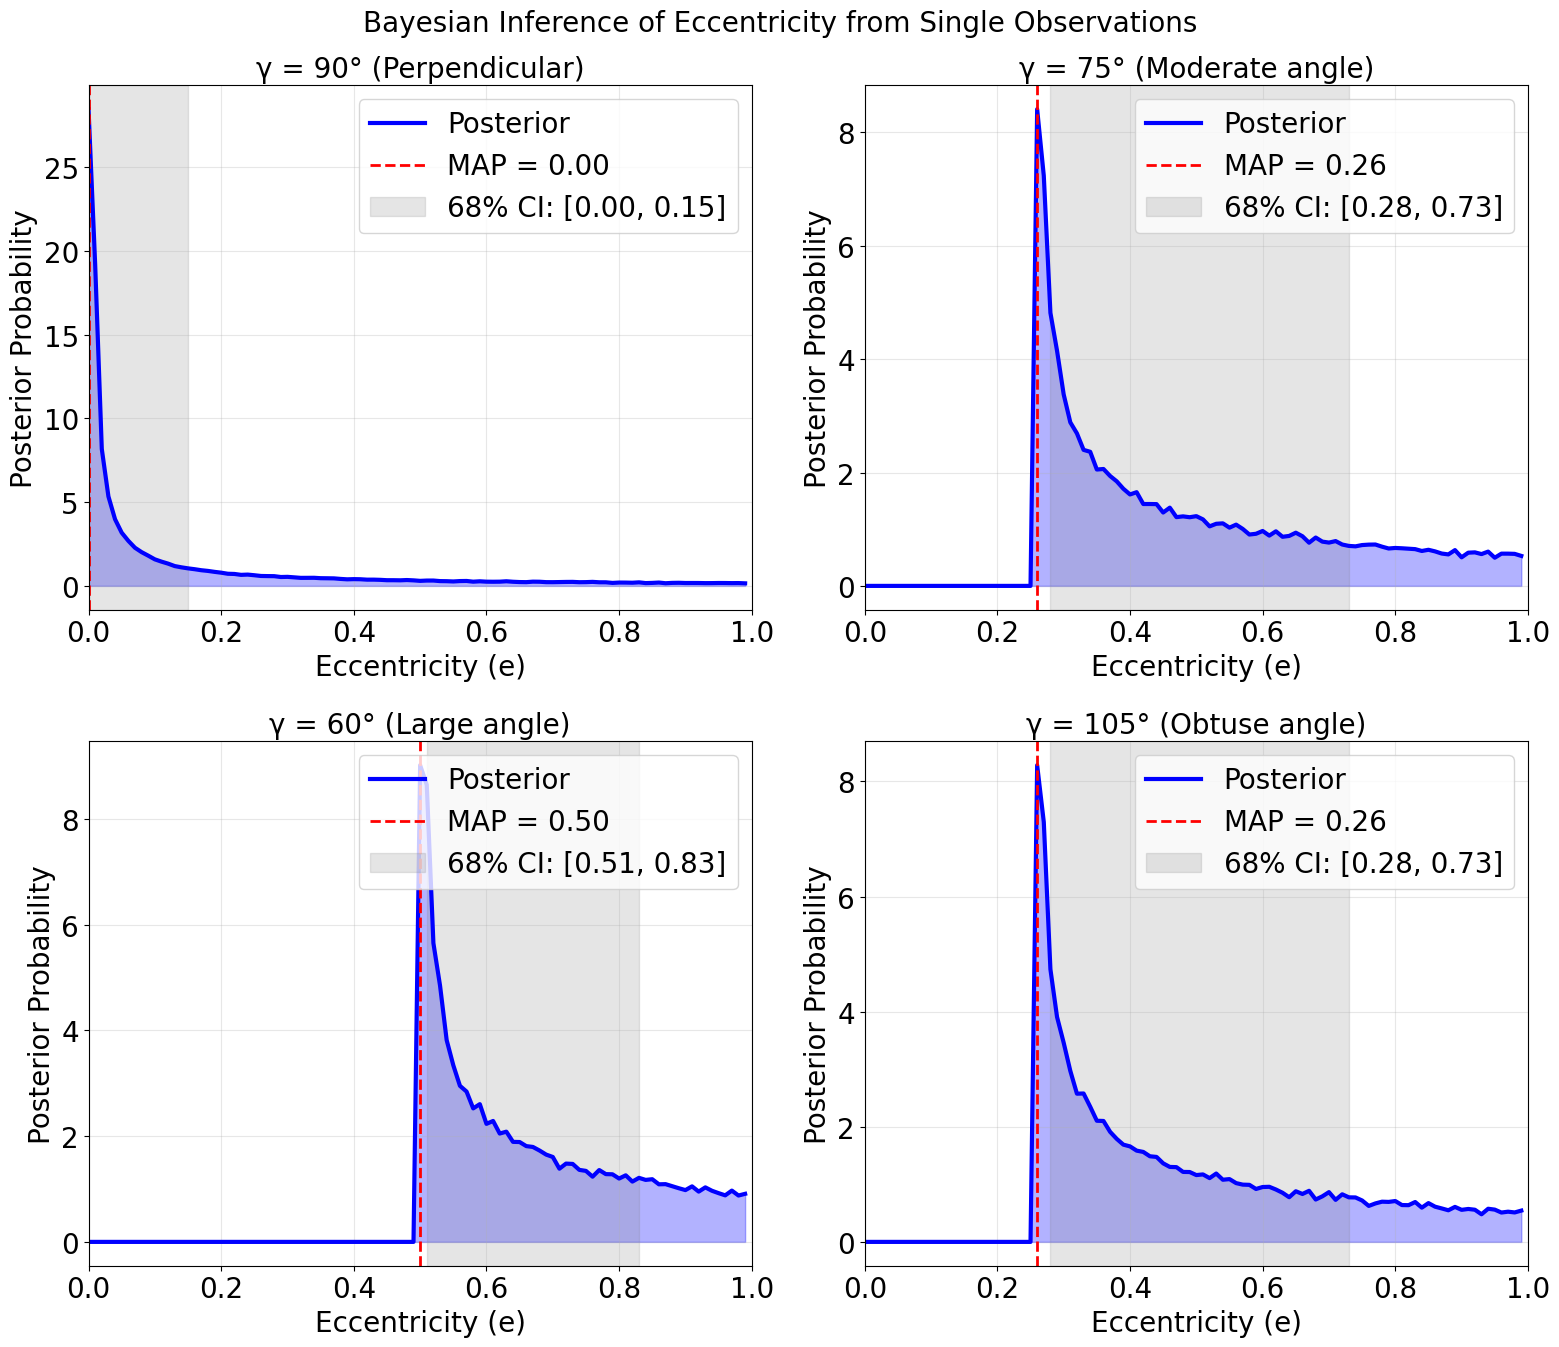

In [15]:
# Demonstrate Bayesian inference for different observations
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Test cases
test_cases = [
    (90, "γ = 90° (Perpendicular)", axes[0,0]),
    (75, "γ = 75° (Moderate angle)", axes[0,1]),
    (60, "γ = 60° (Large angle)", axes[1,0]),
    (105, "γ = 105° (Obtuse angle)", axes[1,1])
]

for gamma_obs, title, ax in test_cases:
    # Calculate posterior
    e_grid, posterior = calculate_posterior(gamma_obs)
    
    # Find maximum a posteriori (MAP) estimate
    map_idx = np.argmax(posterior)
    map_estimate = e_grid[map_idx]
    
    # Calculate credible interval (68%, similar to 1-sigma)
    cumulative = np.cumsum(posterior) * (e_grid[1] - e_grid[0])
    lower_idx = np.argmax(cumulative >= 0.16)
    upper_idx = np.argmax(cumulative >= 0.84)
    
    # Plot posterior
    ax.fill_between(e_grid, 0, posterior, alpha=0.3, color='blue')
    ax.plot(e_grid, posterior, 'b-', linewidth=3, label='Posterior')
    ax.axvline(map_estimate, color='red', linestyle='--', linewidth=2,
               label=f'MAP = {map_estimate:.2f}')
    
    # Shade credible interval
    ax.axvspan(e_grid[lower_idx], e_grid[upper_idx], alpha=0.2, color='gray',
               label=f'68% CI: [{e_grid[lower_idx]:.2f}, {e_grid[upper_idx]:.2f}]')
    
    ax.set_xlabel('Eccentricity (e)')
    ax.set_ylabel('Posterior Probability')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)

plt.suptitle('Bayesian Inference of Eccentricity from Single Observations', 
             fontsize=20, y=0.97)
plt.tight_layout()
plt.show()

An important lesson from this analysis is that Bayesian inference doesn't always require sophisticated computational methods. For this relatively simple inverse problem—inferring a single parameter (eccentricity) from a single observation (angle)—a straightforward grid-based approach works perfectly well.

By evaluating the likelihood on a grid of eccentricity values and applying Bayes' theorem directly, we obtain the full posterior distribution. This approach provides complete information about the uncertainty in our inference while remaining computationally efficient and interpretable. Later in the textbook, we'll encounter high-dimensional problems where grid-based methods become computationally prohibitive, necessitating techniques like MCMC. But for many astronomical applications with one or two parameters, simple grid evaluation remains a viable method.

## Accounting for Orbital Inclination

So far, we've assumed all binary orbits are viewed face-on (inclination i = 0°). In reality, orbital planes are randomly oriented in space, adding another layer of uncertainty to our inference problem. When an orbit is inclined by angle i from face-on, the observed velocity-position angle γ_obs is just a projection of the true 3D angle:

$$\gamma_{obs} = \gamma_{3D} \sin(i)$$

This projection effect means that edge-on systems (i ≈ 90°) show the full range of γ₃D, while nearly face-on systems (i ≈ 0°) always show small observed angles regardless of their eccentricity. Let's explore how this affects our Bayesian inference:

In [16]:
def calculate_posterior_with_inclination(gamma_obs_deg, e_grid=None, n_samples=100000):
    """
    Calculate posterior p(e|γ_obs) accounting for unknown inclination.
    
    Now we must marginalize over both orbital phase φ and inclination i:
    p(γ_obs|e) = ∫∫ p(γ_obs|e,φ,i) p(φ) p(i) dφ di
    
    For isotropic orientation, p(cos i) is uniform, not p(i).
    
    Parameters:
    -----------
    gamma_obs_deg : float
        Observed (projected) angle in degrees
    e_grid : array
        Eccentricity values to evaluate
    n_samples : int
        Number of Monte Carlo samples
        
    Returns:
    --------
    e_grid : array
        Eccentricity values
    posterior : array
        Normalized posterior probability
    """
    if e_grid is None:
        e_grid = np.linspace(0, 0.99, 100)
    
    likelihood = np.zeros_like(e_grid)
    bin_width = 1.0  # degrees
    
    for i, e in enumerate(e_grid):
        # Sample random orbital phases
        phi_samples = np.random.uniform(0, 2*np.pi, n_samples)
        
        # Sample random inclinations (isotropic distribution)
        # For random orientation, cos(i) is uniform, not i itself
        cos_i_samples = np.random.uniform(-1, 1, n_samples)
        sin_i_samples = np.sqrt(1 - cos_i_samples**2)
        
        # Calculate true 3D angles
        cos_gamma_3d = cos_gamma_3D(e, phi_samples)
        gamma_3d_rad = np.arccos(cos_gamma_3d)
        
        # Project by inclination to get observed angles
        gamma_obs_rad = gamma_3d_rad * sin_i_samples
        gamma_obs_samples = np.degrees(gamma_obs_rad)
        
        # Count fraction within observation bin
        within_bin = np.abs(gamma_obs_samples - gamma_obs_deg) < bin_width/2
        likelihood[i] = np.sum(within_bin) / n_samples
    
    # Normalize to get posterior (uniform prior)
    posterior = likelihood / np.trapz(likelihood, e_grid)
    
    return e_grid, posterior

Let's examine how accounting for unknown inclination affects our eccentricity constraints:

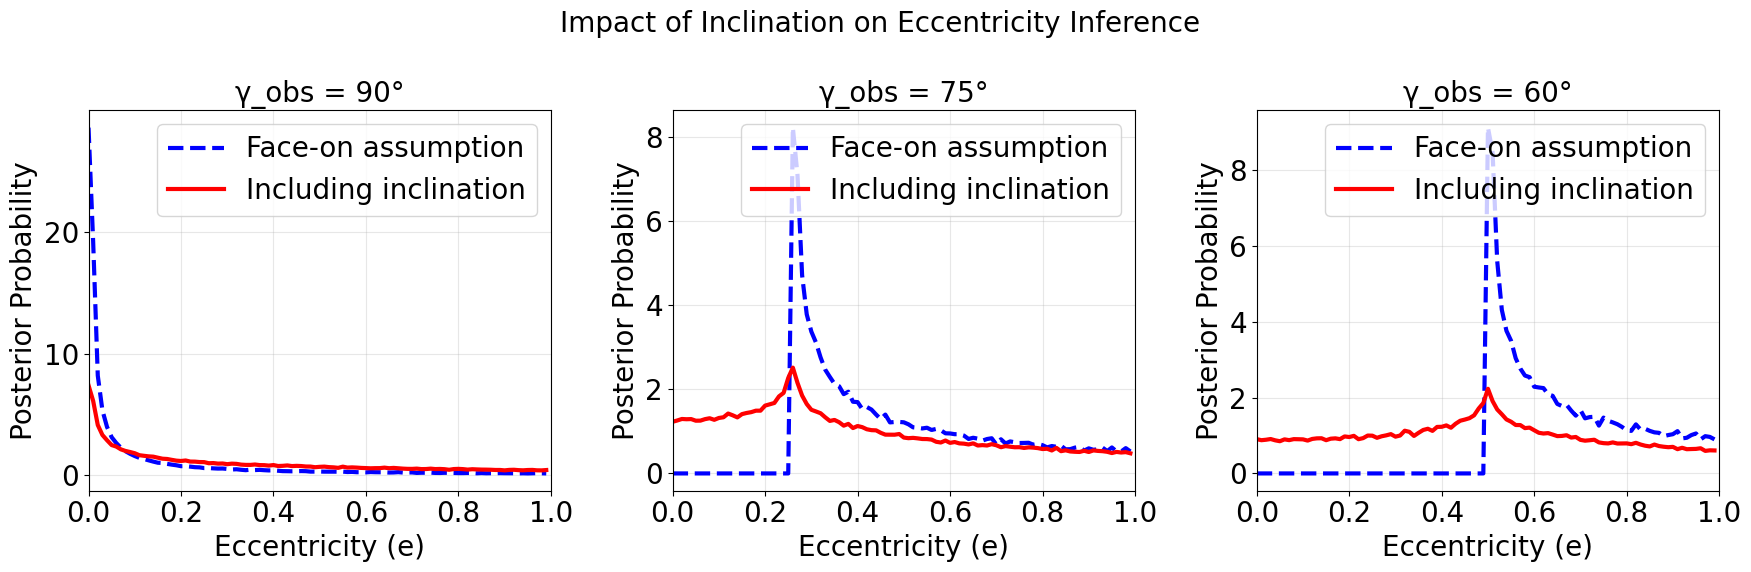

In [17]:
# Compare posteriors with and without inclination for several test angles
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
test_angles = [90, 75, 60]

for idx, gamma_obs in enumerate(test_angles):
    ax = axes[idx]
    
    # Without inclination (face-on assumption)
    e_grid, post_faceon = calculate_posterior(gamma_obs)
    ax.plot(e_grid, post_faceon, 'b--', linewidth=3, 
            label='Face-on assumption')
    
    # With inclination
    e_grid, post_incl = calculate_posterior_with_inclination(gamma_obs)
    ax.plot(e_grid, post_incl, 'r-', linewidth=3,
            label='Including inclination')
    
    ax.set_xlabel('Eccentricity (e)')
    ax.set_ylabel('Posterior Probability')
    ax.set_title(f'γ_obs = {gamma_obs}°')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)

plt.suptitle('Impact of Inclination on Eccentricity Inference', fontsize=20, y=0.97)
plt.tight_layout()
plt.show()

The comparison reveals that inclination uncertainty systematically broadens posterior distributions and shifts probability toward lower eccentricities. This occurs because projection effects allow low-eccentricity orbits viewed at high inclination to produce the same observed angles as high-eccentricity orbits viewed more face-on.

To better understand this geometric effect, let's visualize how inclination affects the observed angle:

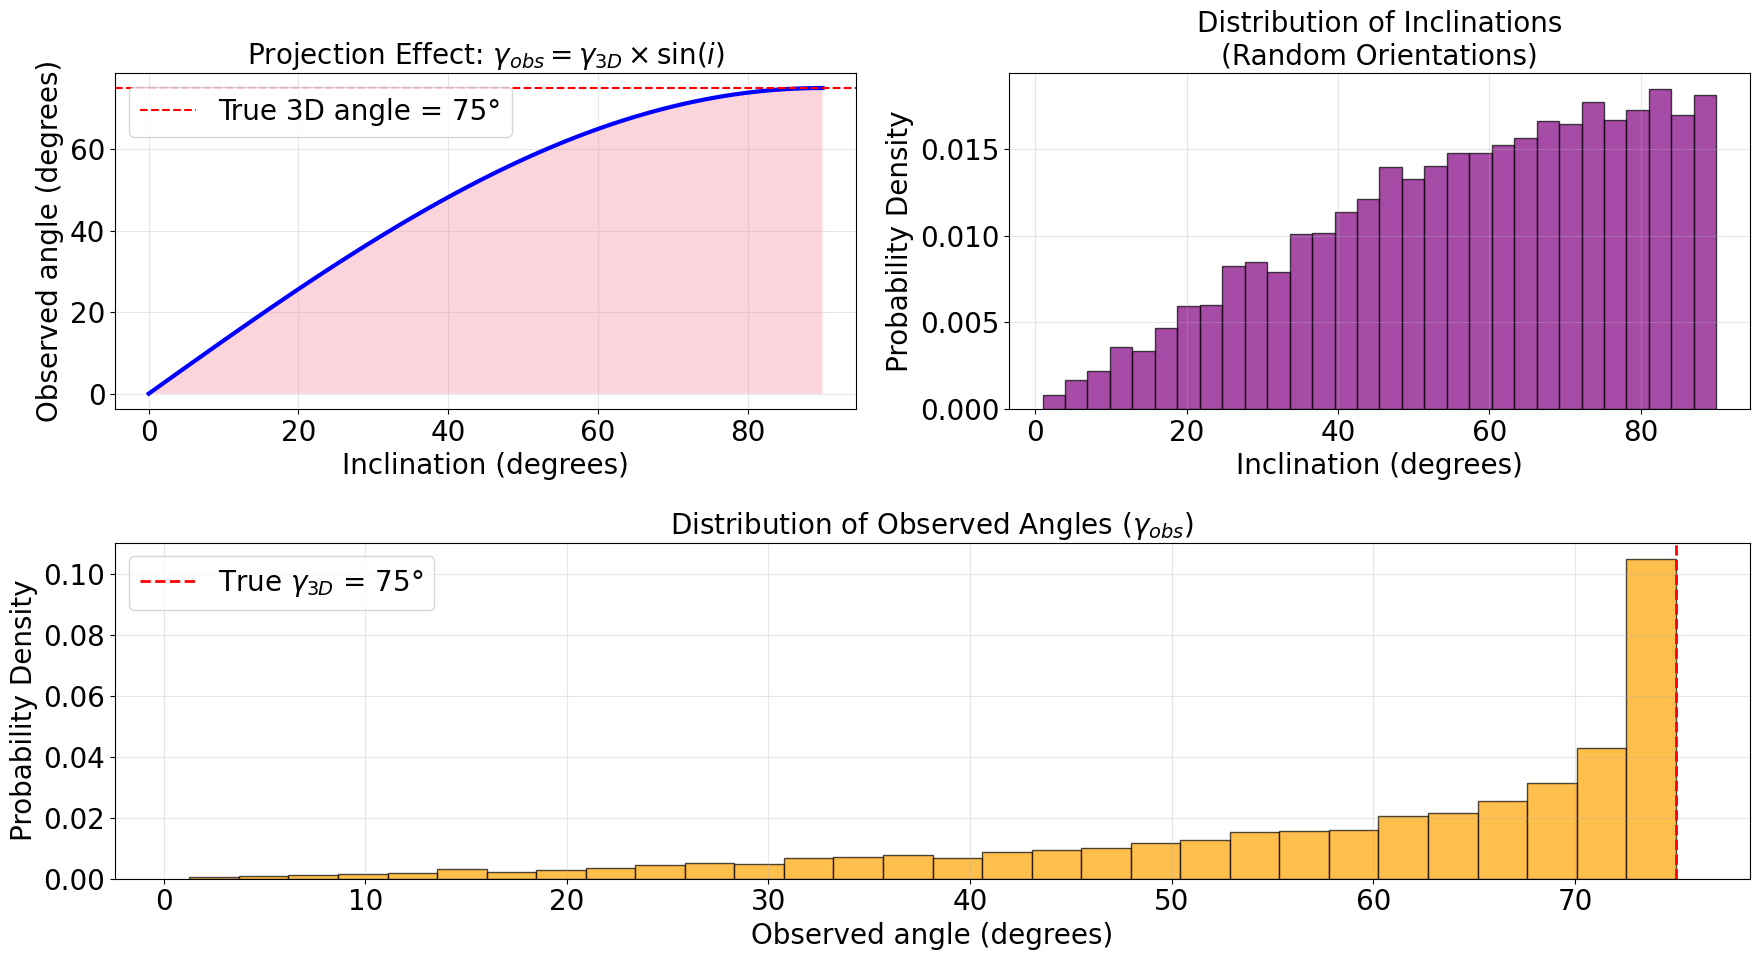

In [18]:
# Visualize the geometry of projection effects
fig = plt.figure(figsize=(18, 10))

# Top left: Show how inclination affects observed angle
ax1 = plt.subplot(2, 2, 1)
inclinations = np.linspace(0, 90, 100)
gamma_3d_test = 75  # degrees
gamma_observed = gamma_3d_test * np.sin(np.radians(inclinations))

ax1.plot(inclinations, gamma_observed, 'b-', linewidth=3)
ax1.axhline(gamma_3d_test, color='red', linestyle='--', 
            label=f'True 3D angle = {gamma_3d_test}°')
ax1.fill_between(inclinations, 0, gamma_observed, alpha=0.3)
ax1.set_xlabel('Inclination (degrees)')
ax1.set_ylabel('Observed angle (degrees)')
ax1.set_title(r'Projection Effect: $\gamma_{obs} = \gamma_{3D} \times \sin(i)$')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Top right: Distribution of inclinations for random orientations
ax2 = plt.subplot(2, 2, 2)
n_random = 10000
cos_i_random = np.random.uniform(-1, 1, n_random)
i_random = np.degrees(np.arccos(np.abs(cos_i_random)))

ax2.hist(i_random, bins=30, density=True, color='purple', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Inclination (degrees)')
ax2.set_ylabel('Probability Density')
ax2.set_title('Distribution of Inclinations\n(Random Orientations)')
ax2.grid(True, alpha=0.3)

# Bottom: Distribution of observed angles
ax3 = plt.subplot(2, 1, 2)
sin_i_random = np.sqrt(1 - cos_i_random**2)
gamma_obs_random = gamma_3d_test * sin_i_random

ax3.hist(gamma_obs_random, bins=30, density=True, color='orange', alpha=0.7, edgecolor='black')
ax3.axvline(gamma_3d_test, color='red', linestyle='--', linewidth=2,
            label=r'True $\gamma_{3D}$ = ' + str(gamma_3d_test) + '°')
ax3.set_xlabel('Observed angle (degrees)')
ax3.set_ylabel('Probability Density')
ax3.set_title(r'Distribution of Observed Angles ($\gamma_{obs}$)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The top-left panel demonstrates the pure geometric projection effect. For a fixed true 3D angle of 75°, the observed angle depends strongly on the system's inclination. Face-on systems (i ≈ 0°) show very small observed angles, while edge-on systems (i ≈ 90°) reveal the full 75°. The shaded region represents all possible observed values for this single true angle.

The top-right panel shows the distribution of inclinations for randomly oriented binary orbits. This distribution peaks near 90° because there are more ways to orient an orbit edge-on than face-on—think of the solid angle on a sphere, where the "equatorial belt" has more area than the "polar caps."

The bottom panel reveals the key insight: when we observe a population of binaries with random orientations, the distribution of observed angles is strongly biased toward lower values. Even though every system has the same true 3D angle of 75°, most observed angles are below 60°. This bias occurs because most systems are viewed at intermediate inclinations where projection effects significantly reduce the observed angle.

These projection effects fundamentally limit what we can infer from single observations. A measured $\gamma_{obs}$ = 30° could arise from a low-eccentricity orbit viewed edge-on or a high-eccentricity orbit viewed more face-on—we cannot distinguish between these scenarios without additional information.

## Incorporating Measurement Uncertainties

In real observations, we don't measure γ perfectly. Our measured angle γ_measured comes with uncertainty, typically characterized by a standard deviation σ_γ. This measurement uncertainty must be incorporated into our Bayesian analysis.

### Marginalizing Over Measurement Uncertainty

When we have measurement uncertainty, our posterior becomes:

$$p(e|\gamma_{measured}) = \int p(e|\gamma_{true}) p(\gamma_{true}|\gamma_{measured}) d\gamma_{true}$$

This equation captures a key Bayesian concept: we marginalize (integrate) over the unknown true value, weighted by how likely each true value is given our measurement. If our measurement uncertainty follows a Gaussian distribution:

$$p(\gamma_{true}|\gamma_{measured}) = \frac{1}{\sqrt{2\pi\sigma_\gamma^2}} \exp\left(-\frac{(\gamma_{true} - \gamma_{measured})^2}{2\sigma_\gamma^2}\right)$$

This integral can be interpreted as a weighted average of posteriors, where the weights come from our measurement uncertainty. Let's see how this affects our inference:

In [19]:
def calculate_posterior_with_measurement_uncertainty(gamma_measured_deg, 
                                                   gamma_uncertainty_deg,
                                                   e_grid=None,
                                                   n_gamma_samples=50):
    """
    Calculate posterior p(e|γ_measured) accounting for measurement uncertainty.
    
    We marginalize over possible true γ values:
    p(e|γ_measured) = ∫ p(e|γ_true) p(γ_true|γ_measured) dγ_true
    
    Parameters:
    -----------
    gamma_measured_deg : float
        Measured angle in degrees
    gamma_uncertainty_deg : float
        Standard deviation of measurement error
    e_grid : array
        Eccentricity values to evaluate
    n_gamma_samples : int
        Number of samples for marginalization integral
        
    Returns:
    --------
    e_grid : array
        Eccentricity values
    posterior : array
        Normalized posterior probability
    """
    if e_grid is None:
        e_grid = np.linspace(0, 0.99, 100)
    
    # Initialize posterior
    posterior = np.zeros_like(e_grid)
    
    # Sample possible true γ values from measurement distribution
    gamma_true_samples = np.random.normal(gamma_measured_deg, 
                                         gamma_uncertainty_deg, 
                                         n_gamma_samples)
    
    # For each possible true γ, calculate p(e|γ_true) and accumulate
    for gamma_true in gamma_true_samples:
        # Skip unphysical angles
        if gamma_true < 0 or gamma_true > 180:
            continue
            
        # Get posterior for this true γ value
        _, post_temp = calculate_posterior(gamma_true)
        
        # Add to weighted average
        posterior += post_temp
    
    # Normalize
    posterior = posterior / np.trapz(posterior, e_grid)
    
    return e_grid, posterior

Let's examine how measurement uncertainty affects our posterior distributions. We'll first look at how increasing uncertainty broadens the posterior for a fixed observation:

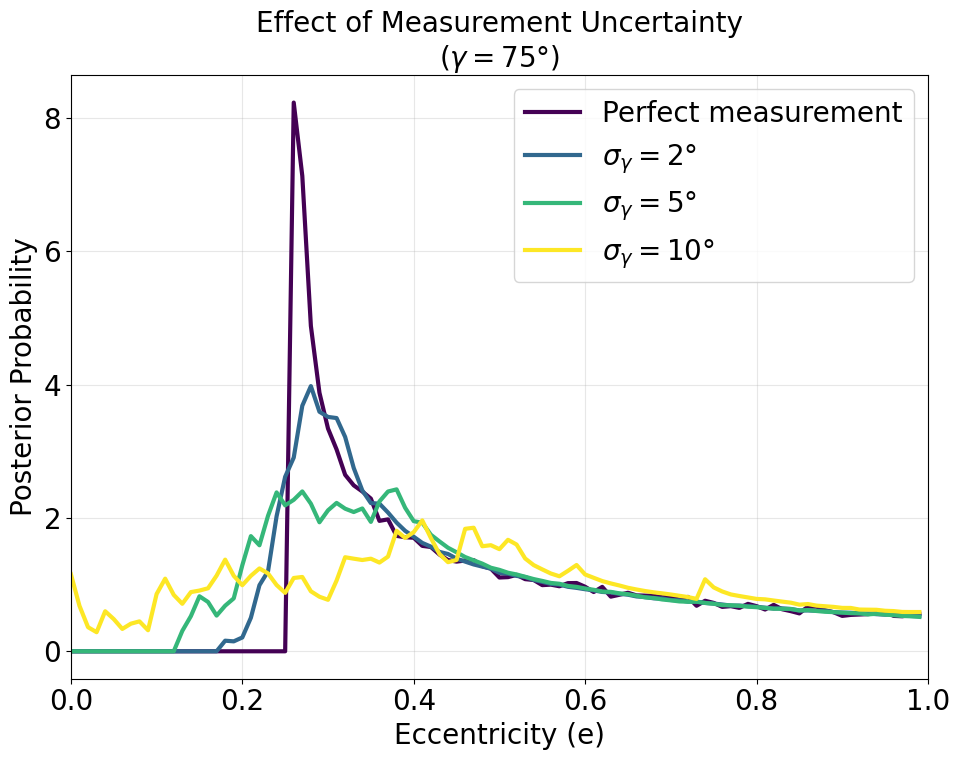

In [20]:
# Demonstrate effect of measurement uncertainty
fig, ax = plt.subplots(figsize=(10, 8))

gamma_measured = 75
uncertainties = [0, 2, 5, 10]  # degrees
colors = plt.cm.viridis(np.linspace(0, 1, len(uncertainties)))

for sigma, color in zip(uncertainties, colors):
    if sigma == 0:
        # Perfect measurement
        e_grid, posterior = calculate_posterior(gamma_measured)
        label = 'Perfect measurement'
    else:
        e_grid, posterior = calculate_posterior_with_measurement_uncertainty(
            gamma_measured, sigma)
        label = r'$\sigma_\gamma = ' + f'{sigma}°$'
    
    ax.plot(e_grid, posterior, color=color, linewidth=3, label=label)

ax.set_xlabel('Eccentricity (e)')
ax.set_ylabel('Posterior Probability')
ax.set_title(r'Effect of Measurement Uncertainty' + f'\n($\\gamma = {gamma_measured}°$)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

The progression from perfect measurement to increasing uncertainty demonstrates how measurement errors systematically broaden the posterior distribution. Large uncertainties can wash out the distinctive features of the posterior, including any multi-modal structure, making it harder to constrain the eccentricity precisely.

Next, let's compare how the same measurement uncertainty affects different observed angles:

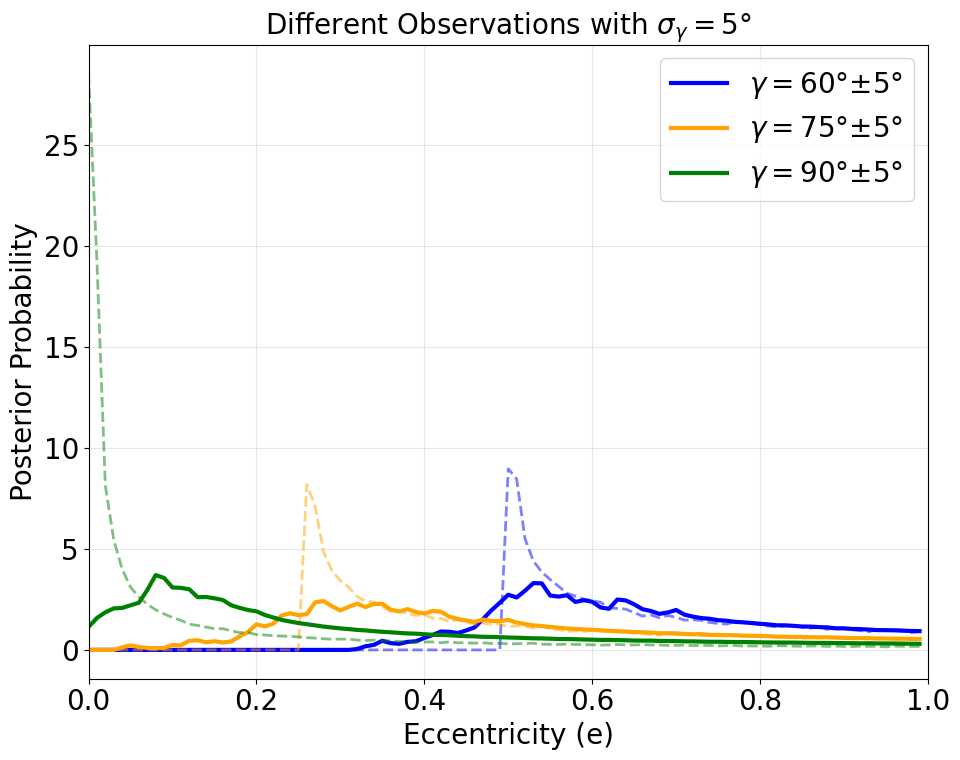

In [21]:
# Compare different γ values with fixed uncertainty
fig, ax = plt.subplots(figsize=(10, 8))

gamma_values = [60, 75, 90]
sigma_fixed = 5  # degrees
colors = ['blue', 'orange', 'green']

for gamma, color in zip(gamma_values, colors):
    # Without uncertainty
    e_grid, post_perfect = calculate_posterior(gamma)
    ax.plot(e_grid, post_perfect, '--', color=color, alpha=0.5, linewidth=2)
    
    # With uncertainty
    e_grid, post_uncertain = calculate_posterior_with_measurement_uncertainty(
        gamma, sigma_fixed)
    ax.plot(e_grid, post_uncertain, '-', color=color, linewidth=3,
            label=r'$\gamma = ' + f'{gamma}° ± {sigma_fixed}°$')

ax.set_xlabel('Eccentricity (e)')
ax.set_ylabel('Posterior Probability')
ax.set_title(r'Different Observations with $\sigma_\gamma = ' + f'{sigma_fixed}°$')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

To gain deeper insight into how measurement uncertainty propagates through our analysis, let's visualize the marginalization process explicitly. We'll show how the final posterior emerges as a weighted average of posteriors for different possible true γ values:

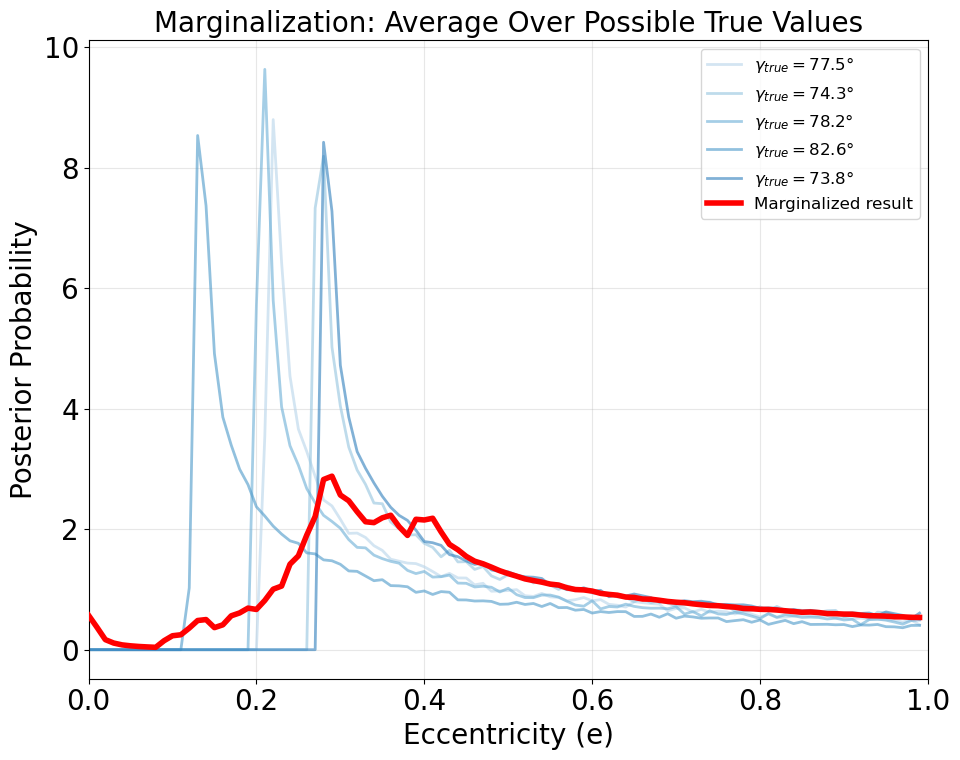

In [22]:
# Visualization of marginalization process
fig, ax = plt.subplots(figsize=(10, 8))

gamma_measured = 75
sigma = 5

# Sample some possible true gamma values
np.random.seed(42)  # For reproducibility
gamma_true_samples = np.random.normal(gamma_measured, sigma, 5)
gamma_true_samples = np.clip(gamma_true_samples, 50, 100)  # Keep reasonable range

# Plot individual posteriors for each possible true gamma
colors_sample = plt.cm.Blues(np.linspace(0.3, 0.7, len(gamma_true_samples)))

for gamma_true, color in zip(gamma_true_samples, colors_sample):
    e_grid, post = calculate_posterior(gamma_true)
    ax.plot(e_grid, post, color=color, alpha=0.6, linewidth=2,
            label=r'$\gamma_{true} = ' + f'{gamma_true:.1f}°$')

# Plot the final marginalized posterior
e_grid, posterior_final = calculate_posterior_with_measurement_uncertainty(
    gamma_measured, sigma)
ax.plot(e_grid, posterior_final, 'r-', linewidth=4, 
        label='Marginalized result', zorder=10)

ax.set_xlabel('Eccentricity (e)')
ax.set_ylabel('Posterior Probability')
ax.set_title('Marginalization: Average Over Possible True Values')
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

Finally, let's examine how different sources of uncertainty—inclination and measurement error—compare in their effects on our inference:

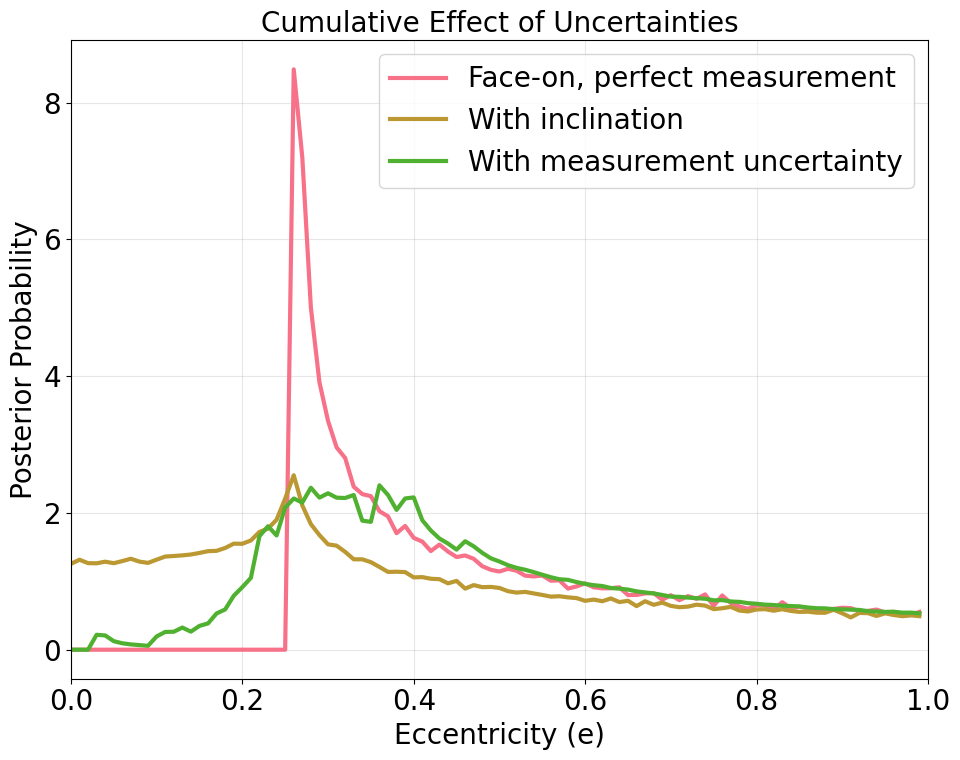

In [23]:
# Comparison - all uncertainty sources
fig, ax = plt.subplots(figsize=(10, 8))

gamma_measured = 75
sigma = 5

# Different levels of realism
e_grid, post1 = calculate_posterior(gamma_measured)
e_grid, post2 = calculate_posterior_with_inclination(gamma_measured)
e_grid, post3 = calculate_posterior_with_measurement_uncertainty(
    gamma_measured, sigma)

ax.plot(e_grid, post1, label='Face-on, perfect measurement', linewidth=3)
ax.plot(e_grid, post2, label='With inclination', linewidth=3)
ax.plot(e_grid, post3, label='With measurement uncertainty', linewidth=3)

ax.set_xlabel('Eccentricity (e)')
ax.set_ylabel('Posterior Probability')
ax.set_title('Cumulative Effect of Uncertainties')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

The comparison reveals how different sources of uncertainty affect our inference in distinct ways. The face-on, perfect measurement case (pink) provides the tightest constraints, with a sharp peak indicating precise eccentricity determination. Including inclination uncertainty (orange) dramatically broadens the posterior and shifts probability toward lower eccentricities, reflecting the degeneracy between high-eccentricity face-on orbits and low-eccentricity edge-on orbits. 

Measurement uncertainty (green) also broadens the posterior but in a different manner—it smooths out sharp features through convolution with the measurement error distribution. Interestingly, for this example, inclination uncertainty has a larger effect than moderate measurement errors, highlighting that projection effects represent a fundamental limitation in single-epoch observations.

These results underscore why comprehensive surveys with precise measurements are crucial for population studies. While single observations with realistic uncertainties provide only broad constraints on individual systems, combining many such measurements can reveal the underlying eccentricity distribution of the population—a key insight that motivated the original work by Hwang et al. (2022).

## Summary

This tutorial has demonstrated how Bayesian inference provides a principled framework for inferring physical parameters from limited observations. Through the example of constraining binary star eccentricities from single-epoch measurements, we've explored fundamental concepts that extend throughout astronomical data analysis:

1. **Likelihood Construction**: We built a forward model connecting orbital eccentricity to observable velocity-position angles, then inverted this relationship through Bayes' theorem.

2. **Grid-Based Inference**: For this low-dimensional problem, direct evaluation on a parameter grid provided complete posterior distributions without requiring sophisticated sampling methods.

3. **Marginalization**: We systematically incorporated multiple sources of uncertainty—unknown orbital phase, inclination, and measurement errors—through integration over nuisance parameters.

4. **Information Content**: Single observations provide broad posteriors due to inherent degeneracies, illustrating why large surveys are essential for population studies.

The techniques developed here form the foundation for more complex astronomical analyses. Whether constraining dark matter halos from stellar kinematics or inferring exoplanet properties from transit photometry, the core principles remain the same: construct a likelihood based on physical understanding, apply Bayes' theorem, and marginalize over uncertainties to obtain robust constraints on parameters of interest.